# USB Webcam

This notebook shows how to use a USB web camera attached to the Pynq-Z1 board. An image is captured using [fswebcam](http://manpages.ubuntu.com/manpages/wily/man1/fswebcam.1.html). The image can then be manipulated using the Python Image Library (Pillow).

The webcam used is the Logitech USB HD Webcam C270 and the driver for this webcam has already been installed on the Pynq-Z1 board image.

#### References
http://pillow.readthedocs.org/en/3.1.x/handbook/tutorial.html<br>
http://manpages.ubuntu.com/manpages/lucid/man1/fswebcam.1.html <br>
http://www.logitech.com/en-us/product/hd-webcam-c270

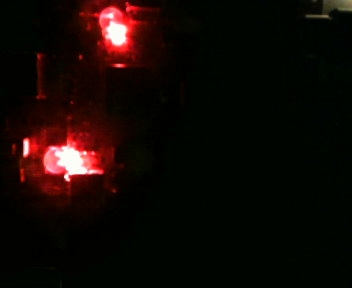

In [151]:
from PIL import Image as PIL_Image

orig_img_path = '/home/xilinx/jupyter_notebooks/common/data/webcam.jpg'
!fswebcam  --no-banner --save {orig_img_path} -d /dev/video0 2> /dev/null

rgb_img = PIL_Image.open(orig_img_path)
rgb_img

In [152]:
# import the necessary packages
from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2

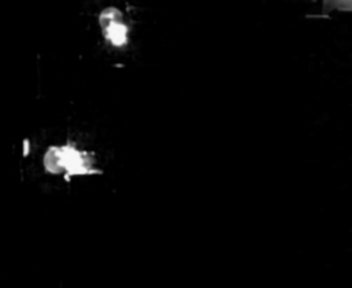

In [153]:
# load the image, convert it to grayscale, and blur it
rgb_array = cv2.imread(orig_img_path)
#rgb_array[:,:,1] = 0
#rgb_array[:,:,2] = 0
#gray_array = cv2.cvtColor(rgb_array, cv2.COLOR_BGR2GRAY)
#blurred = cv2.GaussianBlur(gray_array, (3, 3), 0)
#img = PIL_Image.fromarray(blurred, 'L')
red_channel = rgb_array[:,:,0]
blurred = cv2.GaussianBlur(red_channel, (3, 3), 0)
img = PIL_Image.fromarray(blurred)
img

In [154]:
# threshold the image to reveal light regions in the
# blurred image
thresh = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)[1]

In [155]:
# perform a series of erosions and dilations to remove
# any small blobs of noise from the thresholded image
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=4)

In [156]:
# perform a connected component analysis on the thresholded
# image, then initialize a mask to store only the "large"
# components
labels = measure.label(thresh, neighbors=8, background=0)
mask = np.zeros(thresh.shape, dtype="uint8")

# loop over the unique components
for label in np.unique(labels):
    # if this is the background label, ignore it
    if label == 0:
        continue

    # otherwise, construct the label mask and count the number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)

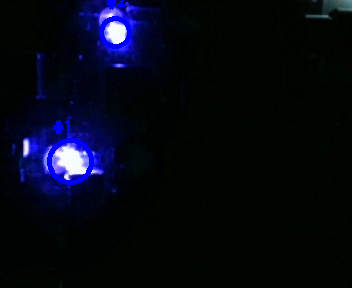

In [157]:
# find the contours in the mask, then sort them from left to
# right
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]
cnts = contours.sort_contours(cnts)[0]
 
# loop over the contours
for (i, c) in enumerate(cnts):
    # draw the bright spot on the image
    (x, y, w, h) = cv2.boundingRect(c)
    ((cX, cY), radius) = cv2.minEnclosingCircle(c)
    cv2.circle(rgb_array, (int(cX), int(cY)), int(radius),
               (0, 0, 255), 3)
    cv2.putText(rgb_array, "#{}".format(i + 1), (x, y - 15),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
img = PIL_Image.fromarray(rgb_array, 'RGB')
img